Hey Folks, in this notebook I'll be going through:
1. Data Analysis
2. Feature Engineering
3. Feature Selection
4. Hyper-parameter Selection
5. Visualize Results and Validate

I remember first encountering this dataset and being intimidated with it, knowing that this is supposed to be an introductory dataset.
So hopefully I can go through some helpful techniques and demystify this process.
The feature engineering techniques will be based on some popular techniques used often with this dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

def feature_engineer(
    df: pd.DataFrame,
    encode_columns: List[str],
    drop_columns
) -> pd.DataFrame:
    """
    Performs feature engineering and encoding for variables included in the encode_columns
    ...
    Parameters
    __________
    df: pd.DataFrame
        The dataframe to be worked on
    encode_columns: List[str] = None
        The columns to perform one-hot encoding on
    drop_columns: List[str] = None
        The columns to drop, not including the encode_columns
    Returns
    _______
    df: pd.DataFrame
        The augmented df including encoded columns and not including drop_columns,
        as well as the new features
    """
    df["Embarked"] = df["Embarked"].fillna("NaN")
    df["Cabin"] = df["Cabin"].fillna("NaN")
    df["CabinLevel"] = df["Cabin"].str[0]
    TicketSize = df["Ticket"].value_counts()
    df["TicketSize"] = df["Ticket"].apply(lambda x: TicketSize[x])
    df["LastNames"] = df["Name"].apply(lambda x: x.split(",")[0])
    df["Title"] = df["Name"].apply(lambda x: x.split(",")[1].split(".")[0])
    df["Title"].value_counts()
    rare_names = df["Title"].unique()[(df["Title"].value_counts() < 10).values]
    rename_dict = {
        "Mlle": "Miss",
        "Mme": "Mrs"
    }
    rare_dict = dict(zip(rare_names, ["Rare"] * len(rare_names)))
    rename_dict.update(rare_dict)
    df["Title"] = df["Title"].replace(rename_dict)
    
    for i in encode_columns:
        for j in df[i].unique():
            df[j] = (df[i] == j).astype(int)
        df = df.drop(columns=i)
    df = df.drop(columns=drop_columns)
    return df

In [2]:
path = r"/kaggle/input/titanic/train.csv"
train = pd.read_csv(path)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
drop_columns = ["Name", "Ticket", "Cabin", "LastNames"]
encode_columns = ["Sex", "Embarked", "CabinLevel", "Title"]
train = feature_engineer(
    df=train,
    encode_columns=encode_columns,
    drop_columns=drop_columns)
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,TicketSize,male,female,...,D,A,B,F,T,Mr,Mrs,Miss,Master,Rare
0,1,0,3,22.0,1,0,7.2500,1,1,0,...,0,0,0,0,0,1,0,0,0,0
1,2,1,1,38.0,1,0,71.2833,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,1,...,0,0,0,0,0,0,0,1,0,0
3,4,1,1,35.0,1,0,53.1000,2,0,1,...,0,0,0,0,0,0,1,0,0,0
4,5,0,3,35.0,0,0,8.0500,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   TicketSize   891 non-null    int64  
 8   male         891 non-null    int64  
 9   female       891 non-null    int64  
 10  S            891 non-null    int64  
 11  C            891 non-null    int64  
 12  Q            891 non-null    int64  
 13  NaN          891 non-null    int64  
 14  N            891 non-null    int64  
 15  E            891 non-null    int64  
 16  G            891 non-null    int64  
 17  D            891 non-null    int64  
 18  A            891 non-null    int64  
 19  B       

In [6]:
X, y = train.drop(columns="Survived"), train["Survived"]
model = XGBClassifier()
feature_selector = RFECV(estimator=model, cv=5, verbose=100, n_jobs=-1).fit(X, y)
best_features = X.columns[feature_selector.support_]
best_features

Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.


Index(['Pclass', 'Age', 'SibSp', 'Fare', 'TicketSize', 'male', 'S', 'N', 'E',
       'D', ' Mr', 'Rare'],
      dtype='object')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

model_ = model.fit(X_train[best_features], y_train)

display(pd.DataFrame(feature_selector.cv_results_).sort_values(by="mean_test_score", ascending=False).head())
permutation_importance_ = permutation_importance(estimator=model, X=X[best_features], y=y, n_jobs=-1)
permutation_importance_ = pd.DataFrame(data=permutation_importance_["importances"].T)
permutation_importance_ = permutation_importance_.rename(columns=dict(zip(range(12), best_features)))
display(permutation_importance_.mean().sort_values())

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
11,0.832785,0.025627,0.821229,0.820225,0.865169,0.797753,0.859551
7,0.820438,0.020911,0.810056,0.797753,0.859551,0.820225,0.814607
8,0.820426,0.025870,0.821229,0.780899,0.859551,0.808989,0.831461
12,0.812560,0.006984,0.821229,0.808989,0.808989,0.803371,0.820225
9,0.811468,0.025846,0.793296,0.803371,0.859551,0.786517,0.814607


Rare          0.000898
D             0.001796
N             0.002469
E             0.003143
SibSp         0.010325
TicketSize    0.023120
S             0.027385
 Mr           0.057015
Pclass        0.058810
Fare          0.087542
male          0.109764
Age           0.121212
dtype: float64

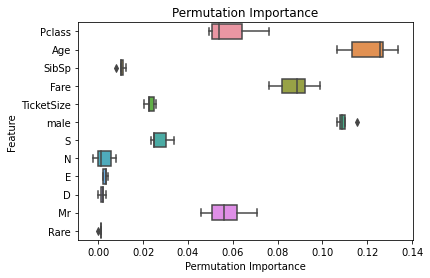

In [8]:
fig, ax = plt.subplots()
sns.boxplot(data=permutation_importance_.melt(), x="value",y="variable", ax=ax)
ax.set_title("Permutation Importance")
ax.set_ylabel("Feature")
ax.set_xlabel("Permutation Importance")
plt.show()

In [9]:
model = XGBClassifier(n_jobs=-1).fit(X[best_features], y)
test = pd.read_csv(r"/kaggle/input/titanic/test.csv")
test = feature_engineer(
    df=test,
    encode_columns=encode_columns,
    drop_columns=drop_columns
)
test["survived"] = model.predict(test[best_features])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          332 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   TicketSize   418 non-null    int64  
 7   male         418 non-null    int64  
 8   female       418 non-null    int64  
 9   Q            418 non-null    int64  
 10  S            418 non-null    int64  
 11  C            418 non-null    int64  
 12  N            418 non-null    int64  
 13  B            418 non-null    int64  
 14  E            418 non-null    int64  
 15  A            418 non-null    int64  
 16  D            418 non-null    int64  
 17  F            418 non-null    int64  
 18  G            418 non-null    int64  
 19   Mr     

In [10]:
test["survived"].value_counts()

0    259
1    159
Name: survived, dtype: int64

In [11]:
test[["PassengerId", "survived"]].to_csv(r"submission.csv", index=False)